# Marriageability - Gaussian Naive Bayes

In [1]:
#Importing Python packages
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import yellowbrick as yb
import os

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")



In [2]:
#Importing CLassifier Packages for Scikitlearn

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, RandomTreesEmbedding,GradientBoostingClassifier)
from sklearn.model_selection import train_test_split

from yellowbrick.classifier import ClassificationReport


# Loading the data

In [3]:
#Load the data
ACSproject = pd.read_csv('data/ACSproject.csv', sep=',', header=0, skipinitialspace=True)

In [4]:
ACSproject.head()

,Unnamed: 0,SERIALNO,SPORDER,PUMA,REGION,ST,CIT,PUMA_T,ST_T,GEOID,...,OCC_PRT,OCC_RPR,OCC_SAL,OCC_SCI,OCC_TRN,OCC_UNE,FAMILY,MULTIGEN,ENGLISH,PWGTP
0,0,2017000000016,1,2500,3,1,1,2500,1,102500,...,0,0,0,0,0,1,0.0,0.0,1.0,206
1,1,2017000000031,1,1800,3,1,1,1800,1,101800,...,0,0,0,0,0,0,0.0,0.0,1.0,45
2,2,2017000000061,1,2400,3,1,1,2400,1,102400,...,0,0,0,0,0,0,0.0,0.0,1.0,136
3,3,2017000000061,2,2400,3,1,1,2400,1,102400,...,0,0,0,0,0,1,0.0,0.0,1.0,121
4,4,2017000000158,1,2500,3,1,1,2500,1,102500,...,0,0,0,0,0,0,0.0,0.0,1.0,18


# Creating Location Features

The GEOID yields(n = 2,378) distint locations in the dataframe. Not enough computing power to run the algorithms. Instead, the project utilizes ST_T (state) in place of location and created Tri_State (0/1) to denote states with economnic and geographic ties.

In [5]:
#Create Tri-state indicator Ex: MD+DC+VA
ACSproject['Tri_State'] = 0
ACSproject.loc[(ACSproject.ST_T ==9) | (ACSproject.ST_T ==10)| (ACSproject.ST_T ==11)|(ACSproject.ST_T ==17)|(ACSproject.ST_T ==18)|(ACSproject.ST_T ==21)|(ACSproject.ST_T ==24)|(ACSproject.ST_T ==34)|(ACSproject.ST_T ==36)|(ACSproject.ST_T ==39)|(ACSproject.ST_T ==42)|(ACSproject.ST_T ==51)|(ACSproject.ST_T ==54), 'Tri_State'] = 1

In [6]:
ACSproject['Tri_State'].value_counts(normalize=False)

0    1981502
1     549224
Name: Tri_State, dtype: int64

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
ACSproject.dtypes

Unnamed: 0      int64
SERIALNO        int64
SPORDER         int64
PUMA            int64
REGION          int64
ST              int64
CIT             int64
PUMA_T          int64
ST_T            int64
GEOID           int64
MARRIED       float64
CITIZEN       float64
MAR_TIMES     float64
MOVER         float64
EDUCATION     float64
WORK_SOC      float64
SEX_T           int64
ESR_T         float64
NATIVITY_T      int64
HEALTH          int64
DIS_T           int64
HISPANIC        int64
WHITE           int64
BLACK           int64
INDIAN          int64
ASIAN           int64
OTHER           int64
AGE_BIN         int64
INCOME_BIN      int64
OCC_BUS         int64
OCC_CMM         int64
OCC_CMS         int64
OCC_CON         int64
OCC_EAT         int64
OCC_EDU         int64
OCC_ENG         int64
OCC_ENT         int64
OCC_EXT         int64
OCC_FFF         int64
OCC_FIN         int64
OCC_HLS         int64
OCC_LGL         int64
OCC_MED         int64
OCC_MGR         int64
OCC_MIL         int64
OCC_OFF   

In [9]:
#Casting all columns as integers
ACSproject.astype('int64').dtypes

Unnamed: 0    int64
SERIALNO      int64
SPORDER       int64
PUMA          int64
REGION        int64
ST            int64
CIT           int64
PUMA_T        int64
ST_T          int64
GEOID         int64
MARRIED       int64
CITIZEN       int64
MAR_TIMES     int64
MOVER         int64
EDUCATION     int64
WORK_SOC      int64
SEX_T         int64
ESR_T         int64
NATIVITY_T    int64
HEALTH        int64
DIS_T         int64
HISPANIC      int64
WHITE         int64
BLACK         int64
INDIAN        int64
ASIAN         int64
OTHER         int64
AGE_BIN       int64
INCOME_BIN    int64
OCC_BUS       int64
OCC_CMM       int64
OCC_CMS       int64
OCC_CON       int64
OCC_EAT       int64
OCC_EDU       int64
OCC_ENG       int64
OCC_ENT       int64
OCC_EXT       int64
OCC_FFF       int64
OCC_FIN       int64
OCC_HLS       int64
OCC_LGL       int64
OCC_MED       int64
OCC_MGR       int64
OCC_MIL       int64
OCC_OFF       int64
OCC_PRD       int64
OCC_PRS       int64
OCC_PRT       int64
OCC_RPR       int64


In [10]:
#One-hot encoding states
ACSproject = pd.get_dummies(ACSproject, columns=['ST'], prefix = 'ST_', drop_first=False)

In [11]:
#Checked to make sure there are no missings
#ACSproject.count()

In [12]:
ACSproject.head()

,Unnamed: 0,SERIALNO,SPORDER,PUMA,REGION,CIT,PUMA_T,ST_T,GEOID,MARRIED,CITIZEN,MAR_TIMES,MOVER,EDUCATION,WORK_SOC,SEX_T,ESR_T,NATIVITY_T,HEALTH,DIS_T,HISPANIC,WHITE,BLACK,INDIAN,ASIAN,OTHER,AGE_BIN,INCOME_BIN,OCC_BUS,OCC_CMM,OCC_CMS,OCC_CON,OCC_EAT,OCC_EDU,OCC_ENG,OCC_ENT,OCC_EXT,OCC_FFF,OCC_FIN,OCC_HLS,OCC_LGL,OCC_MED,OCC_MGR,OCC_MIL,OCC_OFF,OCC_PRD,OCC_PRS,OCC_PRT,OCC_RPR,OCC_SAL,OCC_SCI,OCC_TRN,OCC_UNE,FAMILY,MULTIGEN,ENGLISH,PWGTP,Tri_State,ST__1,ST__2,ST__4,ST__5,ST__6,ST__8,ST__9,ST__10,ST__11,ST__12,ST__13,ST__15,ST__16,ST__17,ST__18,ST__19,ST__20,ST__21,ST__22,ST__23,ST__24,ST__25,ST__26,ST__27,ST__28,ST__29,ST__30,ST__31,ST__32,ST__33,ST__34,ST__35,ST__36,ST__37,ST__38,ST__39,ST__40,ST__41,ST__42,ST__44,ST__45,ST__46,ST__47,ST__48,ST__49,ST__50,ST__51,ST__53,ST__54,ST__55,ST__56
0,0,2017000000016,1,2500,3,1,2500,1,102500,1.0,1.0,1.0,0.0,0.0,0.0,1,0.0,1,1,1,0,0,1,0,0,0,6,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,1.0,206,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2017000000031,1,1800,3,1,1800,1,101800,0.0,1.0,0.0,0.0,3.0,0.0,0,1.0,1,1,0,0,1,0,0,0,0,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,45,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,2017000000061,1,2400,3,1,2400,1,102400,1.0,1.0,2.0,0.0,1.0,0.0,1,1.0,1,1,0,1,0,0,0,0,0,3,7,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,136,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,2017000000061,2,2400,3,1,2400,1,102400,1.0,1.0,2.0,0.0,1.0,0.0,0,0.0,1,1,0,0,1,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,1.0,121,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,2017000000158,1,2500,3,1,2500,1,102500,0.0,1.0,2.0,0.0,1.0,0.0,0,1.0,1,1,0,0,0,1,0,0,0,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,18,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Modeling

In [13]:

# Labeling our X and y data
X = ACSproject[['CITIZEN','MOVER','EDUCATION','WORK_SOC','SEX_T','DIS_T','HISPANIC','WHITE','BLACK','INDIAN','ASIAN','OTHER', 'AGE_BIN', 'INCOME_BIN', 
                'OCC_BUS', 'OCC_CMM','OCC_CMS','OCC_CON', 'OCC_EAT', 'OCC_EDU','OCC_ENG', 'OCC_ENT', 'OCC_EXT', 'OCC_FFF', 
                'OCC_FIN', 'OCC_HLS', 'OCC_LGL', 'OCC_MED', 'OCC_MGR', 'OCC_MIL', 'OCC_OFF', 'OCC_PRD', 'OCC_PRS', 'OCC_PRT', 
                'OCC_RPR', 'OCC_SAL', 'OCC_SCI', 'OCC_TRN', 'OCC_UNE','FAMILY','ENGLISH','Tri_State',
                'ST__1','ST__2','ST__4','ST__5','ST__6','ST__8','ST__9','ST__10','ST__11','ST__12','ST__13',
                'ST__15','ST__16','ST__17','ST__18','ST__19','ST__20','ST__21','ST__22','ST__23','ST__24',
                'ST__25','ST__26','ST__27','ST__28','ST__29','ST__30','ST__31','ST__32','ST__33','ST__34',
                'ST__35','ST__36','ST__37','ST__38','ST__39','ST__40','ST__41','ST__42','ST__44','ST__45',
                'ST__46','ST__47','ST__48','ST__49','ST__50','ST__51','ST__53','ST__54','ST__55','ST__56',
               ]].values

y = ACSproject['MARRIED'].values

#Specify the class of the target
classes = ['Not Married', 'Married']
#Splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)


In [18]:
GNB = GaussianNB() 
#Train the algorithm
GNB.fit(X_train, y_train)
# predict the response
pred = GNB.predict(X_test)
# evaluate accuracy
print ("GaussianNB f1 score : ",f1_score(y_test, pred))

GaussianNB f1 score :  0.650092867823562


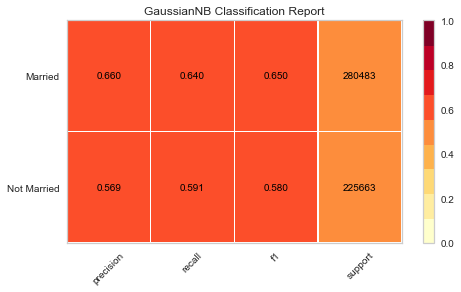

In [19]:
# Visualize GNB
visualizer = ClassificationReport(GNB, classes=classes, support=True, size=(500, 300))
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

## Cross Validation

In [27]:
#GNB CV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
kfold = StratifiedKFold(n_splits=6,shuffle=True,random_state=0)
scores = cross_val_score(GNB, X, y, cv=kfold)
print('Cross-Validation Scores: {}'.format(scores))
print('Average Shuffled Cross-Validation Score: {}'.format(scores.mean()))

Cross-Validation Scores: [0.6168985  0.61797012 0.61781183 0.61823385 0.61987686 0.61787822]
Average Shuffled Cross-Validation Score: 0.6181115627329915


In [ ]:
#End of code.